<a href="https://colab.research.google.com/github/doeungim/ADP_DE/blob/main/ADP_SET_3_DE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
game = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET3/data/game_result.csv')
log = pd.read_csv('//content/drive/MyDrive/ADP_SONY/ADP_SET3/data/log.csv')

인게임 정보데이터는 5분간격의 누적 정보이다. each_variable 컬럼을 만들고 각 variable 별로 증가량값으로 채워넣어라

In [11]:
log

,time,gameId,variable,value,POSITION,TEAM
0,5.0,LA1_1242504360,minionsKilled,33.0,T,blue
1,10.0,LA1_1242504360,minionsKilled,76.0,T,blue
2,15.0,LA1_1242504360,minionsKilled,110.0,T,blue
3,20.0,LA1_1242504360,minionsKilled,143.0,T,blue
4,25.0,LA1_1242504360,minionsKilled,167.0,T,blue
...,...,...,...,...,...,...
1059895,5.0,LA2_1170190226,WARD_KILL,0.0,S,red
1059896,10.0,LA2_1170190226,WARD_KILL,0.0,S,red
1059897,15.0,LA2_1170190226,WARD_KILL,2.0,S,red
1059898,20.0,LA2_1170190226,WARD_KILL,3.0,S,red


In [12]:
# Diff() : 증가량을구해주는 함수
# combine_first : 첫번째 값으로 대체 시켜줌
log['each_variable']= log.groupby(['gameId', 'variable','POSITION','TEAM'])['value'].diff().combine_first(log['value'])

아래의 전처리 조건을 확인하여 작업을 진행하라

변환할 데이터프레임의 컬럼정보

gameId (게임아이디)
* {팀명}{포지션}{variable} 형식으로 컬럼을 추가한다. variable 별로 아래 조건을
만족하는 값을 채워 넣는다.
* {팀명}_{포지션}_minionsKilled : 25분의 minionsKilled value컬럼 값을 추가한다.
* {팀명}_{포지션}_totalGold : each_variable의 다섯 구간 평균값을 추가한다.
* {팀명}_{포지션}_totalDamageTaken : each_variable의 다섯 구간 평균값을 추가한다.
* {팀명}_{포지션}_totalDamageDone : each_variable의 다섯 구간 분산값을 추가한다.
* {팀명}_{포지션}_WARD_PLACED : 15분의 WARD_PLACED value컬럼 값을 추가한다.
* {팀명}_{포지션}_WARD_KILL : each_variable의 max값을 추가한다.
* result : blue팀의 승리여부, 승리 : 1 , 패배 : 0

In [13]:
# result 전처리
result = game[game['TEAM'] == 'blue'][['gameId','win']]
result['result'] = result['win'].astype('int')
result = result[['gameId','result']].reset_index(drop = True).set_index('gameId')

# game_id : index 처리 log와 병합 필요
result.head(4)

,result
gameId,
JP1_340505476,0
JP1_340611094,0
JP1_340621330,0
JP1_340652067,0


In [14]:
# 1. minonskilled
log['target'] = log['TEAM'] + '_' + log['POSITION'] +'_' + log['variable']
m_df = log[(log['variable'] == 'minionsKilled') & (log.time == 25)]
m_df = m_df.pivot_table(index = 'gameId', columns = 'target', values = 'value')

# 2. totalgold
t_df = log[log['variable'] == 'totalGold']
t_df = t_df.pivot_table(index = 'gameId', columns = 'target', values = 'each_variable')
t_df

# 3. total_damage : 5개의 포지션('T', 'J', 'M', 'B', 'S') : 다섯 구간
d_df = log[log['variable'] == 'totalDamageTaken']
d_df = d_df.groupby(['target', 'gameId'])['each_variable'].mean().reset_index()
d_df = d_df.pivot_table(index = 'gameId', columns = 'target', values = 'each_variable')

# 4. totalDamageDone
dd_df = log[log['variable'] == 'totalDamageDone']
dd_df = dd_df.groupby(['target', 'gameId'])['each_variable'].var().reset_index()
dd_df = dd_df.pivot_table(index = 'gameId', columns = 'target', values = 'each_variable')

# 5. WARD_PLACED
w_df = log[(log['variable'] == 'WARD_PLACED') & (log.time == 15)]
w_df = w_df.pivot_table(index = 'gameId', columns = 'target', values = 'value')


# 6. WARD_KILL
ww_df = log[log['variable'] == 'WARD_KILL']
ww_df = ww_df.groupby(['gameId','target'])['each_variable'].max().reset_index()
ww_df = ww_df.pivot_table(index = 'gameId', columns = 'target', values = 'each_variable')


final_df = pd.concat([m_df, t_df, d_df, dd_df, w_df, ww_df, result], axis = 1).reset_index()


전처리한 데이터를 바탕으로 승리 예측 분류 모델을 만들려고한다. 아래의 기준으로 모델링을 하고 평가를 진행하라

* 랜덤포레스트와 그래디언트 부스팅으로 학습한다
* 각 모델별로 3개의 파라미터들을 2개 이상 조합하여 최적의 파라미터를 찾는다.
* 학습데이터는 70%를 사용한다
* auc값으로 평가를 진행하며 ROC Curve를 그려라

In [15]:
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import auc , roc_curve
from sklearn.preprocessing import StandardScaler


X = final_df.drop(columns = ['gameId','result'], axis = 1)
y = final_df['result']

# array 변환
s_X = StandardScaler().fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(s_X, y, test_size = 0.3 , random_state = 1234)

In [16]:
rf = RandomForestClassifier()
gr = GradientBoostingClassifier()

rf_param = {'n_estimators':[50,100,200],'min_samples_split' : [2,3,4],'min_samples_leaf':[1,2,3]}
gr_param = {'learning_rate':[0.1,0.01,0.001],'n_estimators':[50,100,200],'subsample' : [0.05,0.5,1]}

rf_grid = GridSearchCV(rf, rf_param)
gr_grid = GridSearchCV(gr, gr_param)

rf_grid.fit(x_train, y_train)
gr_grid.fit(x_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.05, 0.5, 1]})

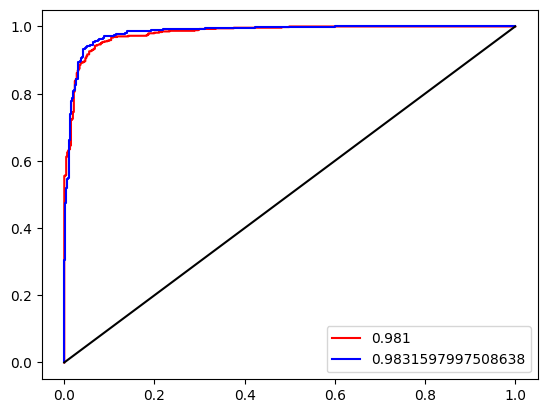

In [17]:
## Feature importance 를 추출하기 위해 best_estimators.predict_proba 사용
import matplotlib.pyplot as plt
# 배열에서 두 번쨰 1만 선택한다는 의미
rf_pred = rf_grid.best_estimator_.predict_proba(x_test)[:,1]
gr_pred = gr_grid.best_estimator_.predict_proba(x_test)[:,1]

# roc_curve
rf_fpr, rf_tpr , threshold = roc_curve(y_test, rf_pred)
gr_fpr, gr_tpr , threshold = roc_curve(y_test, gr_pred)

# auc - fpr, tpr
rf_auc = auc(rf_fpr, rf_tpr )
gr_auc = auc(gr_fpr, gr_tpr)

plt.plot(rf_fpr, rf_tpr, color ='red' , label = f'{rf_auc:.3f}')
plt.plot(gr_fpr, gr_tpr, color ='blue', label = gr_auc)
plt.plot([0,1], [0,1], color = 'black')
plt.legend()

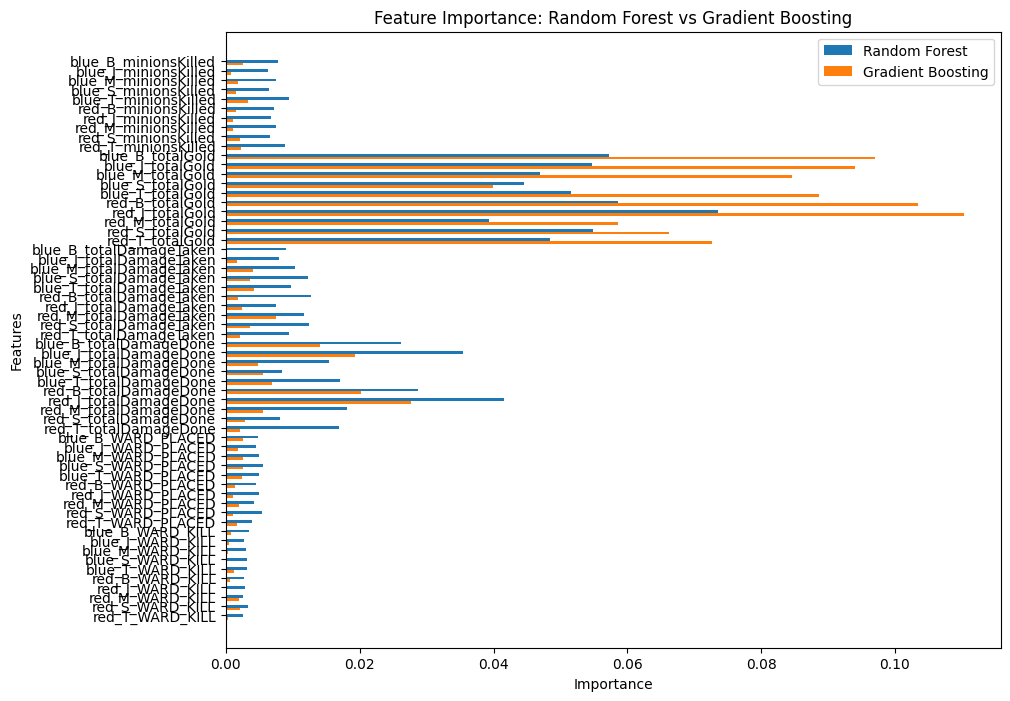

In [18]:
## 변수 중요도 시각화

rf_features = pd.DataFrame({'columns' : X.columns,
                            'importance' : rf_grid.best_estimator_.feature_importances_ })

gr_features = pd.DataFrame({'columns' : X.columns,
                            'importance' : gr_grid.best_estimator_.feature_importances_ })

rf_features['Model'] = 'Random Forest'
gr_features['Model'] = 'Gradient Boosting'

# 두 모델의 변수 중요도 데이터 통합
import numpy as np
combined_features = pd.concat([rf_features, gr_features])

# 변수 중요도 비교 시각화
plt.figure(figsize=(10, 8))
for model in combined_features['Model'].unique():
    subset = combined_features[combined_features['Model'] == model]
    plt.barh(np.arange(len(subset)) + (0.3 if model == 'Gradient Boosting' else 0), subset['importance'], height=0.3, label=model)

plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance: Random Forest vs Gradient Boosting')
plt.yticks(np.arange(len(rf_features)), rf_features['columns'])
plt.legend()
plt.gca().invert_yaxis()
plt.show()

데이터는 특정 폐수 처리시설 주변의 여러 측정센서를 통해 5분간격으로 측정한 데이터이다.

다음의 기준으로 전처리를 시행하고 시각화를 포함한 EDA를 진행하라

* 측정일시별로 측정장소 상관없이 각 측정값들의 최대값 1개만 남겨라.
* 1의 전처리 후 온도 ~ 초미세먼지 값이 모두 0인 데이터 행은 제거하라

In [19]:
df = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET3/data/mc.csv')


# 특정일시별로 측정장소 상관없이 각 측정값들의 최대값 1개만
g = df.groupby('측정일시').max().reset_index()

# 1. 각 컬럼의 합산
g['sum'] = g.iloc[:,2:].sum(axis = 1)
g = g[g['sum'] != 0]

# 2. 장소와 sum 삭제
c_df = g.drop(columns  = ['측정장소', 'sum'])
c_df.head(4)

,측정일시,온도,습도,풍향,풍속,황화수소,암모니아,휘발성유기화합물,강수량,기압,초미세먼지
0,2022-01-10 09:00:00,16.67,81.90,1.0,0.12,14.5,17.0,5849.5,0,1023.2,985.0
1,2022-01-10 09:05:00,16.78,81.65,1.0,0.12,14.0,17.0,6236.0,0,1023.2,985.0
2,2022-01-10 09:10:00,16.86,81.85,1.0,0.11,14.0,15.0,6045.8,0,1023.1,985.0
3,2022-01-10 09:15:00,17.01,81.50,1.0,0.10,13.0,13.4,5617.0,0,1023.2,985.0


In [20]:

# 한글 꺠짐 필요 라이브러리 불러오기
import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt

# apt-get : 패키지 설치 명령어
# -qq : 에러외의 메세지 숨기는 옵션키
!apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 8, 'font.family': 'NanumGothic'}) # 폰트 설정


Selecting previously unselected package fonts-nanum.
(Reading database ... 123597 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


<Axes: >

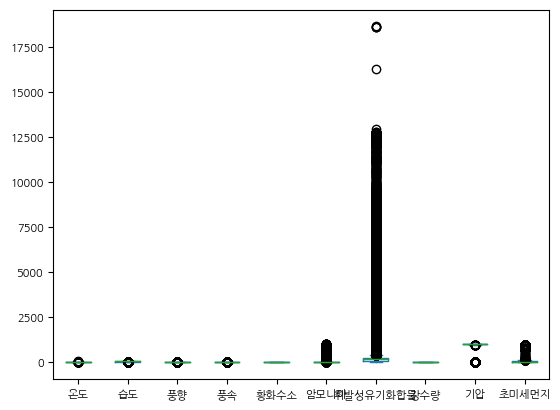

In [21]:
c_df.drop(columns = '측정일시').plot(kind = 'box')

데이터의 측정시간대를 일별 6시간 간격(0 ~ 5시 ,6~12시 ..)으로 나누어 각 컬럼의 수치 평균값을 내라. 각 시간 구간을 0,1,2,3으로 표기하고 date_split 컬럼을 추가한다

In [22]:
def hour(x) :
  if x in range(0,6) :
    return 0
  elif x in range(0, 12) :
    return 1
  elif x in range(12, 18) :
    return 2
  else :
    return 3

c_df['date_split']= pd.to_datetime(c_df['측정일시']).dt.hour.apply(hour)

date_split의 값이 2과 3인 데이터만 필터하고 각 온도~초미세먼지의 컬럼이 date_split 값에 따른 차이가 존재하는지 통계검정하라

In [23]:
c_df.drop(columns =['측정일시','강수량','date_split']).corr()

,온도,습도,풍향,풍속,황화수소,암모니아,휘발성유기화합물,기압,초미세먼지
온도,1.000000,0.262709,0.308983,0.310996,-0.102327,0.354944,0.045560,0.347367,0.258328
습도,0.262709,1.000000,0.409337,0.056882,0.388124,0.078465,0.359727,0.532055,0.239970
풍향,0.308983,0.409337,1.000000,0.429180,0.598564,0.101549,0.102530,0.889619,0.162925
풍속,0.310996,0.056882,0.429180,1.000000,0.173633,0.157059,-0.030827,0.471199,0.049342
황화수소,-0.102327,0.388124,0.598564,0.173633,1.000000,-0.064714,0.088153,0.614410,0.044666
암모니아,0.354944,0.078465,0.101549,0.157059,-0.064714,1.000000,0.001710,0.103861,0.012121
휘발성유기화합물,0.045560,0.359727,0.102530,-0.030827,0.088153,0.001710,1.000000,0.107489,0.092169
기압,0.347367,0.532055,0.889619,0.471199,0.614410,0.103861,0.107489,1.000000,0.175086
초미세먼지,0.258328,0.239970,0.162925,0.049342,0.044666,0.012121,0.092169,0.175086,1.000000


In [58]:
# 2,3별로 온도 초미세 먼지
from scipy.stats import shapiro

df_23 = c_df[c_df['date_split'].isin([2,3])].reset_index(drop = True)
## grouby에서 gruoping 되는 내용만 지정 후, get_group
groups = df_23.groupby('date_split')

# 데이터는 정규분포이다.

lst = []
for col in df_23.drop(columns=['측정일시', 'date_split', '강수량']).columns:
  for i in [2,3] :
    # 2,3 그룹별 data
    grouped_data = groups.get_group(i)[col]

    stat, p = shapiro(grouped_data)
    lst.append([col,f'Group {i}', stat, p])

result = pd.DataFrame(lst, columns = ['Groups','Features', 'Stats','P_val'])
result['result'] = result['P_val'].map(lambda x : '귀무 기각' if x < 0.05 else '귀무 채택')
result

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10104.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10146.
  res = hypotest_fun_out(*samples, **kwds)


,Groups,Features,Stats,P_val,result
0,온도,Group 2,0.960343,6.314930e-46,귀무 기각
1,온도,Group 3,0.940323,4.953364e-53,귀무 기각
2,습도,Group 2,0.947224,8.681720e-51,귀무 기각
3,습도,Group 3,0.896383,2.362307e-63,귀무 기각
4,풍향,Group 2,0.297092,2.195665e-106,귀무 기각
5,풍향,Group 3,0.303834,2.970766e-106,귀무 기각
6,풍속,Group 2,0.974887,1.114481e-38,귀무 기각
7,풍속,Group 3,0.945770,2.451267e-51,귀무 기각
8,황화수소,Group 2,0.940251,5.603898e-53,귀무 기각
9,황화수소,Group 3,0.856815,7.647297e-70,귀무 기각


전처리한 데이터를 바탕으로 초미세먼지를 예측하는 모델을 만들려고한다.
적절한 변수 처리를 하고 다중선형회귀, 랜덤포레스트 모델을 통해 모델 평가를 실시하라. rmse로 평가를 진행한다.

In [76]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.model_selection import train_test_split

X = c_df.drop(columns = ['측정일시','강수량','date_split'])
y = c_df['초미세먼지']

# Model 선언
rf = RandomForestRegressor()
lr = LinearRegression()

# 함수
def modelling(model, name):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    score = mean_squared_error(y_test, pred)
    return {name: score}, model  # 성능 점수와 모델 반환

lst = {}
model_lst = []

# 여러 모델에 대해 반복적으로 적용
for models in ([rf, 'RandomForest'], [lr, 'Linear Regression']):  # 모델과 이름 쌍 반복
    model = models[0]
    name = models[1]
    acc, trained_model = modelling(model, name)  # 함수에서 반환된 값을 저장
    lst.update(acc)  # 성능 점수를 딕셔너리에 추가
    model_lst.append(trained_model)  # 학습된 모델을 리스트에 추가

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(lst.items(), columns=['Model', 'Score'])
print(results_df)


               Model         Score
0       RandomForest  5.167213e+00
1  Linear Regression  5.387997e-25


* 통계1-1
어느 지역의 미세 지진 발생 간격은 평균 10년이다. 이 지진 발생 간격은 지수 분포를 따른다고 가정한다.
최근 지진 이후 5년이 지난 시점에서 7년 이내에 지진이 발생하지 않을 확률은?

In [81]:
from scipy.stats import expon
# 평균 10년
rv = expon(scale = 10)

#  7년의 누적이 일어나지 않을 경우
# 풀이 P(X > 7 | X > 5) - 지수 분포는 기억이 없기 때문에 = P(X > 2)로 계산
# 즉, 2년동안 지진이 발생하지 않은 것과 같음
print(1 - rv.cdf(2))

# 5년이 지난 시점에서 12년 까지 즉, 7년동안 지진이 발생하지 않을 확률
print(1 - rv.cdf(7))

# 지진 발생 후 15년이 지났다. 8년이 이내 지진이 발생할 확률
# P(X < 8)
print(rv.cdf(8))

0.8187307530779818
0.4965853037914095
0.5506710358827784


데이터는 식단과 운동강도에 따라 감량 체중을 기록한 다이어트 프로그램 결과

In [82]:
df = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET3/data/s1.csv')
df.head(4)

,유저,식단,운동,감량체중
0,ID-1,저탄고단,저강도,5.496714
1,ID-2,저탄고단,저강도,4.861736
2,ID-3,저탄고단,저강도,5.647689
3,ID-4,저탄고단,저강도,6.523030


식단과 운동의 조합으로 만들어지는 4개의 그룹들의 각 그룹의 정규성과 그룹간 등분산성을 확인

In [126]:
df['new_gp'] = df['식단'] + '_' + df['운동']

df['new_gp'].value_counts()

,count
new_gp,
저탄고단_저강도,40
저탄고단_고강도,40
저탄고지_저강도,40
저탄고지_고강도,40


In [112]:
# 정규성 확인
# 4개 그룹은 정규 분포이다.
group_list = df['new_gp'].unique()

lst  = []
for group in group_list :
  stat, p = shapiro(df[df['new_gp'] == group]['감량체중'])
  lst.append([group, stat, p])

shapiro_result = pd.DataFrame(lst, columns = ['Groups','Stats','P_val'])
shapiro_result['result'] = shapiro_result['P_val'].map(lambda x : '귀무가설 기각' if x < 0.05 else '귀무가설 채택')
shapiro_result


,Groups,Stats,P_val,result
0,저탄고단_저강도,0.979215,0.660390,귀무가설 채택
1,저탄고단_고강도,0.970413,0.370877,귀무가설 채택
2,저탄고지_저강도,0.968691,0.326866,귀무가설 채택
3,저탄고지_고강도,0.959608,0.162404,귀무가설 채택


In [150]:

## 등분산 검정
from scipy.stats import levene

group_list = df['new_gp'].unique()

data_list = []
lst = []

for group in group_list :
  # 현재 그룹과 나머지 그룹으로 나눔
  group_data = df[df['new_gp'] == group]['감량체중'].values
  not_current_data = df[df['new_gp'] != group]['감량체중'].values

  # levene
  stat, p = levene(group_data, not_current_data)
  lst.append([group, stat, p])

levene_result = pd.DataFrame(lst, columns=['Group', 'Statistic', 'P_value'])

# p-value에 따라 결과 해석 추가
levene_result['Result'] = levene_result['P_value'].map(lambda x: '등분산 가정 기각' if x < 0.05 else '등분산 가정 채택')

# 결과 출력
print(levene_result)



      Group  Statistic   P_value     Result
0  저탄고단_저강도   7.758574  0.006000  등분산 가정 기각
1  저탄고단_고강도   1.241025  0.266965  등분산 가정 채택
2  저탄고지_저강도   5.806914  0.017113  등분산 가정 기각
3  저탄고지_고강도   3.403176  0.066943  등분산 가정 채택


이원분산분석을 진행하려한다. 2-1의 결과를 바탕으로 모수,비모수 방법을 결정하고 주효과에 대한 가설과 교호작용 효과에 대한 가설을 설정하라.

- 주효과
  * 귀무가설 : 식단에 상관없이 감량체중은 같다.
  * 대립가설 : 적어도 하나의 식단에 따라 감량 체중이 다르다.

  * 귀무가설 : 운동에 상관없이 감량 체중은 같다
  * 대립가설 : 적어도 하나의 운동에 따라 감량 체중이 다르다.

- 교호작용
  * 귀무가설 : 식단과 운동은 교호작용이 있다.
  * 대립가설 : 식단과 운동으 교호작용이 없다.

In [151]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('감량체중 ~ C(식단) * C(운동)', data = df).fit()
anva_table = sm.stats.anova_lm(model, typ = 2)
anva_table

,sum_sq,df,F,PR(>F)
C(식단),16.257434,1.0,18.352972,3.198226e-05
C(운동),70.040700,1.0,79.068753,1.401288e-15
C(식단):C(운동),0.714673,1.0,0.806792,3.704546e-01
Residual,138.187955,156.0,NaN,NaN


 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
저탄고단고강도 저탄고단저강도  -1.1896    0.0 -1.7361 -0.6431   True
저탄고단고강도 저탄고지고강도  -0.5039 0.0824 -1.0504  0.0427  False
저탄고단고강도 저탄고지저강도  -1.9608    0.0 -2.5073 -1.4142   True
저탄고단저강도 저탄고지고강도   0.6857 0.0074  0.1392  1.2323   True
저탄고단저강도 저탄고지저강도  -0.7712 0.0019 -1.3177 -0.2247   True
저탄고지고강도 저탄고지저강도  -1.4569    0.0 -2.0035 -0.9104   True
------------------------------------------------------


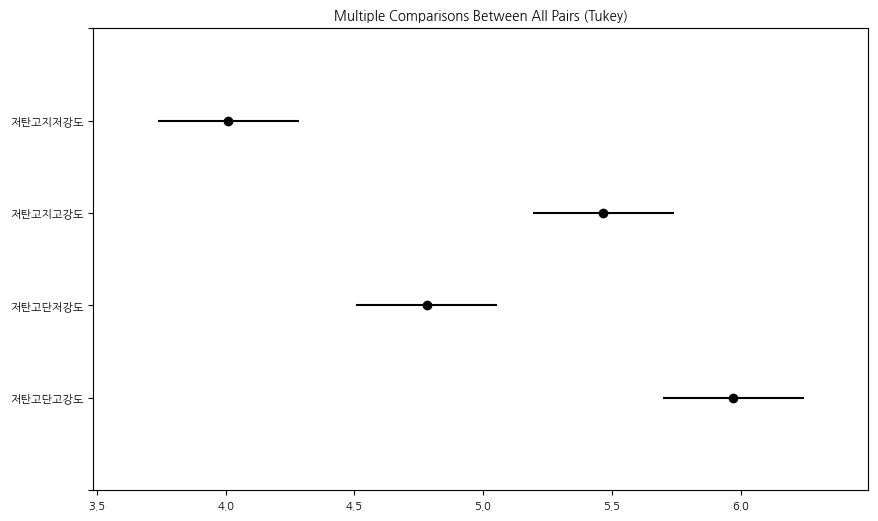

In [157]:
# 사후검정
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(df['감량체중'], df['식단'] + df['운동'], alpha = 0.05)
print(tukey.summary())

tukey.plot_simultaneous()
plt.show()

통계 3
- 나이와 성별, 급여 관련한 정보이다. 구매여부(Purchased)를 예측하는 로지스틱 회귀 모델을 만드려고 한다.
- 0,2,3,4 의 인덱스 : 테스트 데이터 / 나머지 학습 데이터
- Gender 더미화, 나이와 봉급은 표준화

In [159]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET3/data/s3.csv')
df.head(10)

,Age,EstimatedSalary,Gender,Purchased
0,22,19000,0,0
1,25,20000,1,0
2,47,43000,0,1
3,52,46000,1,1
4,46,22000,1,0
5,56,80000,0,1
6,55,76000,0,1
7,60,83000,1,1
8,62,81000,1,1
9,61,89000,0,1


In [209]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = df.drop(columns = 'Purchased', axis = 1)
X['Gender'] = X.Gender.astype('str')

X_1 = pd.get_dummies(X).astype('int')


X_2 = StandardScaler().fit_transform(X_1)
XX = pd.DataFrame(X_2, columns = X_1.columns)

# y
y = df['Purchased'].reset_index(drop= True)


In [210]:
# train
x_test = XX.iloc[[0,2,3,4 ],:]
y_test = y.iloc[[0,2,3,4 ]]

## train
index = [0,2,3,4]
x_train = XX.iloc[~XX.index.isin(index), :]
y_train = y.iloc[~y.index.isin(index)]

# 모델
lr = LogisticRegression()
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)

lr_score = accuracy_score(y_test, lr_pred)
print(lr_score)


0.75


test데이터에 대해 예측하지 못한 레이블이 있다면 해당 데이터의 레이블 별 예측확률을 추출

In [214]:

# 예측이 틀린 데이터 찾기
wrong_prediction = x_test[lr_pred != y_test]
wrong_label = y_test[lr_pred != y_test]

# 예측이 틀린 데이터에 대한 확률 확인하기
lr.predict_proba(wrong_prediction)

array([[0.44176886, 0.55823114]])

새로운 샘플 케이스가 들어왔고 해당 데이터의 더미화 및 표준화의 결과 후 값은 다음과

In [223]:
x = np.array([-0.6, -1.8, 0,1])
# 변수별 회귀 계수와 절편값을 통해 계산한 z값과 시그모이드 함수 출력 결과를 각각 구하여라

z = np.dot(x,lr.coef_.T) + lr.intercept_

result =  1 / (1 + np.exp(-z))
print(z , result)

[-0.17422726] [0.45655303]


3-1에서 학습한 모델의 각 변수들의 오즈비를 계산하여 출력하고 가장 많은 오즈가 증가하는 피쳐를 확인하

In [225]:
cf = lr.coef_[0]
odds = np.exp(lr.coef_[0])
odds

array([2.0473107 , 1.89189682, 1.2755891 , 0.78395151])